In [64]:
from dataclasses import dataclass, field
from typing import List, Dict, Optional
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import seaborn as sns

In [65]:
# Essential font settings
plt.rcParams['font.family'] = 'serif'  # Or 'sans-serif' for a cleaner look
plt.rcParams['font.size'] = 12  # Good baseline size
plt.rcParams['axes.titlesize'] = 16  # Larger title
plt.rcParams['axes.labelsize'] = 14  # Slightly larger axis labels
plt.rcParams['xtick.labelsize'] = 12  # Readable tick labels
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Text quality improvements
plt.rcParams['text.antialiased'] = True  # Smoother text
plt.rcParams['axes.formatter.use_mathtext'] = True  # Better formatting for scientific notation

# Title and label spacing
plt.rcParams['axes.titlepad'] = 12  # Space between title and plot
plt.rcParams['axes.labelpad'] = 8  # Space between axis and label

# Figure resolution for clear text
plt.rcParams['figure.figsize'] = (10, 6)  # Good default size
plt.rcParams['figure.dpi'] = 100  # Screen display
plt.rcParams['savefig.dpi'] = 300  # High quality when saving
plt.rcParams['savefig.bbox'] = 'tight'  # Prevents text cutoff

In [66]:
import re

def clean_district_names(df, column_name):
    """
    Removes state abbreviations in parentheses and trims whitespace from district names.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the district names
    column_name : str
        Name of the column containing district names with state abbreviations
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with cleaned district names in the specified column
    """
    # Create a copy to avoid modifying the original DataFrame
    df_cleaned = df.copy()
    
    # Use regex to remove the state abbreviation pattern:
    # - Optional whitespace before parenthesis
    # - Open parenthesis
    # - 2-3 uppercase letters 
    # - Close parenthesis
    # - Optional whitespace after parenthesis
    # - Must be at the end of the string
    df_cleaned[column_name] = df_cleaned[column_name].str.replace(r'\s*\([A-Z]{2,3}\)\s*$', '', regex=True)
    
    # Trim any leading/trailing whitespace
    df_cleaned[column_name] = df_cleaned[column_name].str.strip()
    
    return df_cleaned

In [67]:
vietnam_relationship = pd.read_csv('./data/relationshiptable_VN.csv')
vietnam_changes = pd.read_excel('./data/changes_VN.xlsx')

In [68]:
vietnam_changes.drop(columns=['Unnamed: 4', 'Unnamed: 5'], inplace=True, errors='ignore')

In [71]:
boundaries = gpd.read_file('./shapefiles/hdx_2020/vnm_admbnda_adm1_gov_20201027.shp')

# Match names in vietnam_relationship and changes file with boundaries

In [72]:
#Get all names from the from_unit_name and the to_unit_name columns
to_unit_changes = vietnam_changes['to_unit_name'].str.split(',').explode().str.strip().unique()
from_unit_changes = vietnam_changes['from_unit_name'].unique()
change_names = to_unit_changes.tolist() + from_unit_changes.tolist()

#Get relationship table names
relationship_names = vietnam_relationship['from_unit_name'].str.split(',').str[0].str.strip().unique().tolist()

#All names from relationship table and changes
all_names = list(set(change_names + relationship_names))

#Get all names from the boundaries
boundary_names = boundaries['ADM1_EN']

In [73]:
#Find any names that are in the boundaries but not in the relationship table or changes
missing_from_changes = set(boundary_names) - set(all_names)
missing_from_boundaries = set(all_names) - set(boundary_names)

print("Missing from changes:", missing_from_changes)
print("Missing from boundaries:", missing_from_boundaries)

Missing from changes: {'Can Tho city', 'Da Nang city', 'Ho Chi Minh city', 'Hai Phong city'}
Missing from boundaries: {'Phu Khanh', 'Cao Lang', 'Nam Ha', 'Vinh Phu', 'Ba Ria-Vung Tau', 'Hai Hung', 'Nghe Tinh', 'Thuan Hai', 'Ha Nam Ninh', 'Ha Son Binh', 'Quang Nam-Da Nang', 'Da Nang', 'Ha Bac', 'Song Be', 'Gia Lai-Kon Tum', 'Ha Tay', 'Da Nang City', 'Hai Phong City', 'Bac Thai', 'Can Tho City', 'Ha Noi City', 'Ha Tuyen', 'Ho Chi Minh City', 'Ha Sonh Binh', 'Vung Tau-Con Dao', 'Cuu Long', 'Minh Hai', 'Nghia Binh', 'Min Hai', 'Thua Thien', 'Can Tho', 'Binh Tri Thien', 'Hoang Lien Son'}


In [74]:
# Capitalize the word city in the boundary names
boundaries['ADM1_EN'] = boundaries['ADM1_EN'].str.replace(r'\bcity\b', 'City', case=False, regex=True)

In [75]:
boundaries['ADM1_EN'].replace('Ha Noi', 'Ha Noi City', inplace=True, regex=True)

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_87974/449696832.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  boundaries['ADM1_EN'].replace('Ha Noi', 'Ha Noi City', inplace=True, regex=True)


# Now that the boundaries have names accounted for in the relationship and changes, we can start to aggregate the units

In [76]:
import pandas as pd
import geopandas as gpd
from collections import defaultdict
import networkx as nx

def parse_province_names(province_string):
    """
    Parse a province string that may contain multiple comma-separated province names.
    
    This is like parsing a guest list - "John, Mary, Bob" means three separate people,
    not one person with a weird compound name.
    
    Parameters:
    -----------
    province_string : str
        String containing one or more province names separated by commas
        
    Returns:
    --------
    list
        List of individual province names
    """
    if pd.isna(province_string) or province_string == '':
        return []
    
    # Split by comma and clean up whitespace
    provinces = [name.strip() for name in str(province_string).split(',')]
    # Remove empty strings
    provinces = [name for name in provinces if name]
    
    return provinces

def build_province_groups(changes_df):
    """
    Build groups of provinces that should be aggregated based on historical changes.
    
    Now correctly handles comma-separated province names as separate entities.
    This is like building a family tree where provinces that have interacted 
    (merged, split, renamed) are all part of the same extended family.
    
    Parameters:
    -----------
    changes_df : pandas.DataFrame
        DataFrame with columns: year, change_type, from_unit_name, to_unit_name
        where from_unit_name and to_unit_name may contain comma-separated province names
    
    Returns:
    --------
    dict
        Dictionary mapping group_id to list of all province names in that group
    """
    # Create a graph where each province is a node, and edges represent interactions
    G = nx.Graph()
    
    # Add all province names as nodes, properly parsing comma-separated names
    all_provinces = set()
    
    for _, row in changes_df.iterrows():
        # Parse comma-separated province names
        from_provinces = parse_province_names(row['from_unit_name'])
        to_provinces = parse_province_names(row['to_unit_name'])
        
        # Add all provinces to our set
        all_provinces.update(from_provinces)
        all_provinces.update(to_provinces)
        
        # Connect all provinces involved in this change
        # If A, B -> C, D then A connects to C and D, B connects to C and D
        for from_prov in from_provinces:
            for to_prov in to_provinces:
                G.add_edge(from_prov, to_prov)
        
        # Also connect provinces within the same side of a change
        # If A, B -> C then A also connects to B (they were involved in same change)
        for i, prov1 in enumerate(from_provinces):
            for prov2 in from_provinces[i+1:]:
                G.add_edge(prov1, prov2)
                
        for i, prov1 in enumerate(to_provinces):
            for prov2 in to_provinces[i+1:]:
                G.add_edge(prov1, prov2)
    
    # Add any isolated nodes (provinces that appear but might not have connections)
    G.add_nodes_from(all_provinces)
    
    # Find connected components (groups of provinces that have interacted)
    connected_components = list(nx.connected_components(G))
    
    # Convert to dictionary format
    province_groups = {}
    for i, component in enumerate(connected_components):
        province_groups[f"group_{i+1}"] = sorted(list(component))
    
    return province_groups

def get_all_historical_names(changes_df, province_names):
    """
    Get all historical names for a group of provinces, including rename chains.
    
    Now correctly handles comma-separated province names in the changes file.
    This is like tracing a person's name changes over time - if Province A was 
    renamed to Province B, then B to Province C, we want to capture A, B, and C
    as all referring to the same geographic entity.
    
    Parameters:
    -----------
    changes_df : pandas.DataFrame
        DataFrame with change records
    province_names : list
        List of current province names in the group
        
    Returns:
    --------
    set
        Set of all historical names for provinces in this group
    """
    all_names = set(province_names)
    
    # For each province in the group, find all names it has had
    for province in province_names:
        # Find all records where this province was involved
        relevant_changes = []
        
        for _, row in changes_df.iterrows():
            from_provinces = parse_province_names(row['from_unit_name'])
            to_provinces = parse_province_names(row['to_unit_name'])
            
            # Check if this province appears in either side of the change
            if province in from_provinces or province in to_provinces:
                relevant_changes.append(row)
        
        # Add all names from these records
        for row in relevant_changes:
            from_provinces = parse_province_names(row['from_unit_name'])
            to_provinces = parse_province_names(row['to_unit_name'])
            all_names.update(from_provinces)
            all_names.update(to_provinces)
    
    return all_names

def get_earliest_change_year(changes_df, province_names):
    """
    Get the earliest year when any of the provinces in the group had a change.
    
    Now correctly handles comma-separated province names in the changes file.
    
    Parameters:
    -----------
    changes_df : pandas.DataFrame
        DataFrame with change records
    province_names : list
        List of province names in the group
        
    Returns:
    --------
    int
        Earliest year of change
    """
    # Get all historical names for this group
    all_historical_names = get_all_historical_names(changes_df, province_names)
    
    relevant_years = []
    
    for _, row in changes_df.iterrows():
        from_provinces = parse_province_names(row['from_unit_name'])
        to_provinces = parse_province_names(row['to_unit_name'])
        all_row_provinces = set(from_provinces + to_provinces)
        
        # Check if any province in this row is in our historical names
        if all_row_provinces.intersection(all_historical_names):
            relevant_years.append(row['year'])
    
    if not relevant_years:
        return None
    
    return min(relevant_years)

def create_hybrid_name(province_names, max_length=50):
    """
    Create a hybrid name for aggregated provinces.
    
    Parameters:
    -----------
    province_names : list
        List of province names to combine
    max_length : int
        Maximum length for the combined name
        
    Returns:
    --------
    str
        Combined name
    """
    if len(province_names) == 1:
        return province_names[0]
    
    # Sort names for consistency
    sorted_names = sorted(province_names)
    
    # Try to create a reasonable combined name
    combined = " + ".join(sorted_names)
    
    return combined

    # if len(combined) <= max_length:
    #     return combined
    
    # # If too long, use first few names + "etc"
    # partial = ""
    # for name in sorted_names:
    #     test_name = partial + name if not partial else partial + " + " + name
    #     if len(test_name + " + etc") > max_length:
    #         break
    #     partial = test_name
    
    # return partial + " + etc" if len(sorted_names) > 1 else sorted_names[0]

def merge_vietnam_provinces(gdf, province_group, hybrid_name, group_id, earliest_year):
    """
    Merge Vietnam provinces based on a group of province names.
    
    This function is like creating a composite photo from multiple individual photos -
    we combine all the geographic boundaries into one unified shape while keeping
    track of all the original pieces.
    
    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame containing Vietnam province boundaries with 'ADM1_EN' column
    province_group : list
        List of province names to merge (as they appear in ADM1_EN)
    hybrid_name : str
        Name for the merged boundary
    group_id : str
        Unique identifier for this group
    earliest_year : int
        Earliest year when changes occurred in this group
    
    Returns:
    --------
    tuple
        (modified_gdf, provinces_found, provinces_missing)
    """
    # Ensure required columns exist
    if 'merged_provinces' not in gdf.columns:
        gdf['merged_provinces'] = ''
    if 'is_hybrid' not in gdf.columns:
        gdf['is_hybrid'] = False
    if 'group_id' not in gdf.columns:
        gdf['group_id'] = ''
    if 'earliest_change_year' not in gdf.columns:
        gdf['earliest_change_year'] = None
    
    # Find provinces that exist in the shapefile
    provinces_to_merge = gdf[gdf['ADM1_EN'].isin(province_group)]
    provinces_found = provinces_to_merge['ADM1_EN'].tolist()
    provinces_missing = [p for p in province_group if p not in provinces_found]
    
    if len(provinces_found) == 0:
        print(f"Warning: No provinces found for group {group_id}")
        return gdf, provinces_found, provinces_missing
    
    if len(provinces_missing) > 0:
        print(f"Warning: {len(provinces_missing)} provinces not found in shapefile for group {group_id}: {provinces_missing}")
    
    # If only one province found, just update its metadata
    if len(provinces_found) == 1:
        idx = provinces_to_merge.index[0]
        gdf.loc[idx, 'merged_provinces'] = ', '.join(sorted(province_group))
        gdf.loc[idx, 'is_hybrid'] = True
        gdf.loc[idx, 'group_id'] = group_id
        gdf.loc[idx, 'earliest_change_year'] = earliest_year
        return gdf, provinces_found, provinces_missing
    
    # Merge geometries
    indices_to_drop = provinces_to_merge.index
    merged_geometry = provinces_to_merge.dissolve()
    
    # Create new row with merged data
    new_row = {}
    
    # Copy structure from original GDF
    for col in gdf.columns:
        if col == gdf._geometry_column_name:
            new_row[col] = merged_geometry.iloc[0].geometry
        elif col == 'ADM1_EN':
            new_row[col] = hybrid_name
        elif col == 'merged_provinces':
            new_row[col] = ', '.join(sorted(province_group))
        elif col == 'is_hybrid':
            new_row[col] = True
        elif col == 'group_id':
            new_row[col] = group_id
        elif col == 'earliest_change_year':
            new_row[col] = earliest_year
        else:
            # For other columns, use the first available value or None
            available_values = provinces_to_merge[col].dropna()
            new_row[col] = available_values.iloc[0] if len(available_values) > 0 else None
    
    # Create new GeoDataFrame row
    new_gdf = gpd.GeoDataFrame([new_row], geometry=gdf._geometry_column_name, crs=gdf.crs)
    
    # Remove original provinces and add merged one
    gdf_filtered = gdf.drop(indices_to_drop)
    final_gdf = pd.concat([gdf_filtered, new_gdf], ignore_index=True)
    
    return final_gdf, provinces_found, provinces_missing

def create_vietnam_hybrid_boundaries(gdf, changes_df, min_group_size=2, include_renames=True):
    """
    Create hybrid boundaries for Vietnam by aggregating provinces that have interacted.
    
    Think of this as creating administrative "super-regions" where provinces that have
    a shared history (merges, splits, renames) are grouped together for consistent
    analysis across different time periods.
    
    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame with Vietnam province boundaries (must have 'ADM1_EN' column)
    changes_df : pandas.DataFrame
        DataFrame with change records (columns: year, change_type, from_unit_name, to_unit_name)
    min_group_size : int
        Minimum number of provinces in a group to create a hybrid boundary (default: 2)
    include_renames : bool
        Whether to include rename-only groups (group size = 1) as hybrid boundaries
    
    Returns:
    --------
    tuple
        (hybrid_gdf, group_mapping, processing_log)
        - hybrid_gdf: GeoDataFrame with hybrid boundaries
        - group_mapping: Dict mapping group_id to province names
        - processing_log: List of processing messages
    """
    # Create a copy to avoid modifying original
    result_gdf = gdf.copy()
    processing_log = []
    
    # Build province groups based on interactions
    province_groups = build_province_groups(changes_df)
    processing_log.append(f"Found {len(province_groups)} interaction groups")
    
    # Identify which groups represent pure renames (size 1 groups that had rename changes)
    rename_groups = set()
    regular_groups = {}
    
    for group_id, province_names in province_groups.items():
        if len(province_names) == 1 and include_renames:
            # Check if this single province was involved in rename operations
            single_province = province_names[0]
            rename_changes = changes_df[
                ((changes_df['from_unit_name'] == single_province) | 
                 (changes_df['to_unit_name'] == single_province)) &
                (changes_df['change_type'] == 'rename')
            ]
            
            if not rename_changes.empty:
                rename_groups.add(group_id)
                regular_groups[group_id] = province_names
            # If size 1 but no renames, this province had no changes - only keep if meets min_group_size
            elif len(province_names) >= min_group_size:
                regular_groups[group_id] = province_names
        elif len(province_names) >= min_group_size:
            regular_groups[group_id] = province_names
    
    # The groups we want to process
    filtered_groups = regular_groups
    
    processing_log.append(
        f"Processing {len(regular_groups) - len(rename_groups)} multi-province groups and "
        f"{len(rename_groups)} rename groups"
    )
    
    group_mapping = {}
    
    # Process each group
    for group_id, province_names in filtered_groups.items():
        # Get earliest change year for this group
        earliest_year = get_earliest_change_year(changes_df, province_names)
        
        # Create hybrid name
        hybrid_name = create_hybrid_name(province_names)
        
        # Merge provinces
        result_gdf, found, missing = merge_vietnam_provinces(
            result_gdf, province_names, hybrid_name, group_id, earliest_year
        )
        
        # Update group mapping with what was actually found
        group_mapping[group_id] = {
            'hybrid_name': hybrid_name,
            'all_provinces': province_names,
            'all_historical_names': sorted(list(get_all_historical_names(changes_df, province_names))),
            'found_provinces': found,
            'missing_provinces': missing,
            'earliest_change_year': earliest_year,
            'is_rename_only': len(province_names) == 1 and group_id in rename_groups
        }
        
        processing_log.append(
            f"{group_id}: {hybrid_name} - "
            f"{'RENAME' if group_id in rename_groups else 'MERGE'} - "
            f"merged {len(found)} provinces ({len(missing)} missing from shapefile)"
        )
    
    return result_gdf, group_mapping, processing_log

# Example usage function
def example_usage_with_name_matching():
    """
    Example of how to use the hybrid boundary functions with name matching.
    """
    # Load your data
    # gdf = gpd.read_file('vietnam_provinces.shp')
    # changes_df = pd.read_excel('changes.xlsx')
    
    # Step 1: Analyze name mismatches
    # analysis = analyze_name_mismatches(gdf, changes_df, name_col='ADM1_EN')
    # 
    # print("=== NAME MATCHING ANALYSIS ===")
    # print(f"Total shapefile names: {analysis['summary']['total_shapefile_names']}")
    # print(f"Total changes names: {analysis['summary']['total_changes_names']}")
    # print(f"Exact matches: {analysis['summary']['exact_matches']}")
    # print(f"Missing in shapefile: {analysis['summary']['missing_in_shapefile']}")
    # 
    # print("\n=== FUZZY MATCHES (SUGGESTED MAPPINGS) ===")
    # for changes_name, matches in analysis['fuzzy_matches'].items():
    #     print(f"'{changes_name}' -> {matches}")
    # 
    # print("\n=== NAMES MISSING IN SHAPEFILE ===")
    # for name in analysis['missing_in_shapefile']:
    #     print(f"  {name}")
    
    # Step 2: Create name mapping (you'll need to customize this based on analysis)
    # name_mapping = {
    #     'Ha Noi': 'Ha Noi City',  # Example mapping
    #     'Phu Yen, Khanh Hoa': 'Phu Yen',  # Map compound names to primary component
    #     # Add more mappings based on your analysis
    # }
    
    # Step 3: Apply name mapping to changes file
    # changes_df_mapped = apply_name_mapping(changes_df, name_mapping)
    
    # Step 4: Create hybrid boundaries with mapped names
    # hybrid_gdf, group_mapping, log = create_vietnam_hybrid_boundaries(
    #     gdf, changes_df_mapped, min_group_size=2, include_renames=True
    # )
    
    # Step 5: Review results
    # for message in log:
    #     print(message)
    
    pass

def debug_your_current_issue():
    """
    Specific debugging for your current name matching issues.
    """
    # Based on your output, here are the likely mappings you need:
    suggested_mappings = {
        # Historical merged provinces that don't exist in modern shapefile
        'Bac Thai': 'DELETE_OR_SPLIT',  # Split into Bac Kan + Thai Nguyen
        'Ha Bac': 'DELETE_OR_SPLIT',    # Split into Bac Giang + Bac Ninh  
        'Hai Hung': 'DELETE_OR_SPLIT',  # Split into Hai Duong + Hung Yen
        'Quang Nam-Da Nang': 'DELETE_OR_SPLIT',  # Split into Quang Nam + Da Nang
        'Nghia Binh': 'DELETE_OR_SPLIT',  # Split into Quang Ngai + Binh Dinh
        'Phu Khanh': 'DELETE_OR_SPLIT',   # Split into Phu Yen + Khanh Hoa
        'Thuan Hai': 'DELETE_OR_SPLIT',   # Split into Ninh Thuan + Binh Thuan
        'Gia Lai-Kon Tum': 'DELETE_OR_SPLIT',  # Split into Gia Lai + Kon Tum
        'Dac Khu Vung Tau Con Dao': 'Ba Ria-Vung Tau',  # Likely renamed
        
        # City vs province naming
        'Ha Noi': 'Ha Noi City',  # If that's how it appears in shapefile
        
        # Compound names - map to individual components
        'Phu Yen, Khanh Hoa': 'Phu Yen',  # Choose primary component
        'Bac Kan, Thai Nguyen': 'Bac Kan',  # Choose primary component
        # ... add more as needed
    }
    
    print("=== SUGGESTED NAME MAPPINGS ===")
    for old_name, new_name in suggested_mappings.items():
        print(f"'{old_name}' -> '{new_name}'")
    
    print("\n=== INSTRUCTIONS ===")
    print("1. Run analyze_name_mismatches() on your data to see exact mismatches")
    print("2. Create a name_mapping dict with corrections")
    print("3. Use apply_name_mapping() to fix the changes DataFrame")
    print("4. Re-run create_vietnam_hybrid_boundaries() with corrected data")
    
    return suggested_mappings

# Debugging utility to analyze name mismatches
def analyze_name_mismatches(gdf, changes_df, name_col='ADM1_EN'):
    """
    Analyze mismatches between province names in shapefile and changes file.
    
    Now correctly handles comma-separated province names in changes file.
    This is like being a detective trying to match different spellings of the same name -
    we need to find where "John Smith" in one list corresponds to "J. Smith" in another.
    
    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame with province boundaries
    changes_df : pandas.DataFrame
        DataFrame with change records
    name_col : str
        Column name containing province names in shapefile
        
    Returns:
    --------
    dict
        Analysis results with suggestions for name matching
    """
    # Get all names from shapefile
    shapefile_names = set(gdf[name_col].tolist())
    
    # Get all names from changes file, properly parsing comma-separated names
    changes_names = set()
    for _, row in changes_df.iterrows():
        from_provinces = parse_province_names(row['from_unit_name'])
        to_provinces = parse_province_names(row['to_unit_name'])
        changes_names.update(from_provinces)
        changes_names.update(to_provinces)
    
    # Find exact matches
    exact_matches = shapefile_names.intersection(changes_names)
    
    # Find names in changes but not in shapefile
    missing_in_shapefile = changes_names - shapefile_names
    
    # Find names in shapefile but not in changes
    missing_in_changes = shapefile_names - changes_names
    
    # Try to find fuzzy matches for missing names
    fuzzy_matches = {}
    
    for missing_name in missing_in_shapefile:
        potential_matches = []
        missing_lower = missing_name.lower().strip()
        
        for shapefile_name in shapefile_names:
            shapefile_lower = shapefile_name.lower().strip()
            
            # Check if one is contained in the other
            if missing_lower in shapefile_lower or shapefile_lower in missing_lower:
                potential_matches.append(shapefile_name)
            
            # Check for similar names (allowing for minor differences)
            if abs(len(missing_lower) - len(shapefile_lower)) <= 3:
                # Simple similarity check
                common_chars = set(missing_lower).intersection(set(shapefile_lower))
                if len(common_chars) >= min(4, len(missing_lower) - 1):
                    potential_matches.append(shapefile_name)
        
        if potential_matches:
            fuzzy_matches[missing_name] = potential_matches
    
    return {
        'exact_matches': sorted(list(exact_matches)),
        'missing_in_shapefile': sorted(list(missing_in_shapefile)),
        'missing_in_changes': sorted(list(missing_in_changes)),
        'fuzzy_matches': fuzzy_matches,
        'summary': {
            'total_shapefile_names': len(shapefile_names),
            'total_changes_names': len(changes_names),
            'exact_matches': len(exact_matches),
            'missing_in_shapefile': len(missing_in_shapefile),
            'potential_fuzzy_matches': len(fuzzy_matches)
        }
    }

def create_name_mapping_suggestions(analysis_results):
    """
    Create suggestions for mapping province names between datasets.
    
    Parameters:
    -----------
    analysis_results : dict
        Results from analyze_name_mismatches()
        
    Returns:
    --------
    dict
        Suggested name mappings
    """
    suggestions = {}
    
    # Add fuzzy matches as suggestions
    for changes_name, potential_matches in analysis_results['fuzzy_matches'].items():
        if len(potential_matches) == 1:
            suggestions[changes_name] = potential_matches[0]
        else:
            # Multiple matches - need manual review
            suggestions[changes_name] = f"MANUAL_REVIEW: {potential_matches}"
    
    return suggestions

def apply_name_mapping(changes_df, name_mapping):
    """
    Apply name mapping to standardize province names in changes file.
    
    Parameters:
    -----------
    changes_df : pandas.DataFrame
        Original changes DataFrame
    name_mapping : dict
        Dictionary mapping old names to new names
        
    Returns:
    --------
    pandas.DataFrame
        Changes DataFrame with standardized names
    """
    df_mapped = changes_df.copy()
    
    # Apply mapping to both from_unit_name and to_unit_name columns
    df_mapped['from_unit_name'] = df_mapped['from_unit_name'].replace(name_mapping)
    df_mapped['to_unit_name'] = df_mapped['to_unit_name'].replace(name_mapping)
    
    return df_mapped

# Additional utility function for data aggregation
def aggregate_data_by_hybrid_boundaries(data_df, group_mapping, province_col, value_cols, year_col=None):
    """
    Aggregate data based on the hybrid boundary groupings.
    
    This is like consolidating financial records - if you have data for provinces
    that should be treated as one unit, this function sums them up appropriately.
    
    Parameters:
    -----------
    data_df : pandas.DataFrame
        DataFrame with your data to aggregate
    group_mapping : dict
        The group_mapping returned by create_vietnam_hybrid_boundaries
    province_col : str
        Name of the column containing province names in data_df
    value_cols : list
        List of columns to sum when aggregating
    year_col : str, optional
        Name of year column if you want to aggregate by year as well
        
    Returns:
    --------
    pandas.DataFrame
        Aggregated data with hybrid boundary names
    """
    # Create a mapping from original province names to hybrid names
    province_to_hybrid = {}
    for group_id, info in group_mapping.items():
        hybrid_name = info['hybrid_name']
        for province_name in info['all_historical_names']:
            province_to_hybrid[province_name] = hybrid_name
    
    # Add hybrid boundary column to data
    data_df = data_df.copy()
    data_df['hybrid_boundary'] = data_df[province_col].map(province_to_hybrid)
    
    # Handle provinces not in any hybrid boundary (keep their original names)
    data_df['hybrid_boundary'] = data_df['hybrid_boundary'].fillna(data_df[province_col])
    
    # Set up grouping columns
    group_cols = ['hybrid_boundary']
    if year_col:
        group_cols.append(year_col)
    
    # Aggregate the data
    agg_dict = {col: 'sum' for col in value_cols}
    
    # Keep first value for non-numeric columns
    for col in data_df.columns:
        if col not in value_cols + group_cols + [province_col]:
            if data_df[col].dtype in ['object', 'string']:
                agg_dict[col] = 'first'
    
    aggregated = data_df.groupby(group_cols).agg(agg_dict).reset_index()
    
    return aggregated

In [77]:
# Create hybrid boundaries (including renames)
hybrid_gdf, group_mapping, log = create_vietnam_hybrid_boundaries(
    boundaries, vietnam_changes, min_group_size=2, include_renames=True
)

# Print processing log
for message in log:
    print(message)

# Check what names to use for each hybrid boundary
for group_id, info in group_mapping.items():
    print(f"\n{info['hybrid_name']}:")
    print(f"  Current provinces: {info['found_provinces']}")
    print(f"  All historical names: {info['all_historical_names']}")
    print(f"  Rename only: {info['is_rename_only']}")
    print(f"  First change: {info['earliest_change_year']}")

# Save results
# hybrid_gdf.to_file('vietnam_hybrid_boundaries.shp')



Found 23 interaction groups
Processing 23 multi-province groups and 0 rename groups
group_1: Cao Bang + Cao Lang + Lang Son - MERGE - merged 2 provinces (1 missing from shapefile)
group_2: Ha Nam + Ha Nam Ninh + Nam Dinh + Nam Ha + Ninh Binh - MERGE - merged 3 provinces (2 missing from shapefile)
group_3: Ha Noi + Ha Son Binh + Ha Tay + Hoa Binh - MERGE - merged 1 provinces (3 missing from shapefile)
group_4: Ha Giang + Ha Tuyen + Tuyen Quang - MERGE - merged 2 provinces (1 missing from shapefile)
group_5: Hoang Lien Son + Lao Cai + Yen Bai - MERGE - merged 2 provinces (1 missing from shapefile)
group_6: Ha Tinh + Nghe An + Nghe Tinh - MERGE - merged 2 provinces (1 missing from shapefile)
group_7: Binh Tri Thien + Quang Binh + Quang Tri + Thua Thien + Thua Thien Hue - MERGE - merged 3 provinces (2 missing from shapefile)
group_8: Binh Dinh + Nghia Binh + Quang Ngai - MERGE - merged 2 provinces (1 missing from shapefile)
group_9: Khanh Hoa + Phu Khanh + Phu Yen - MERGE - merged 2 provin

<Axes: >

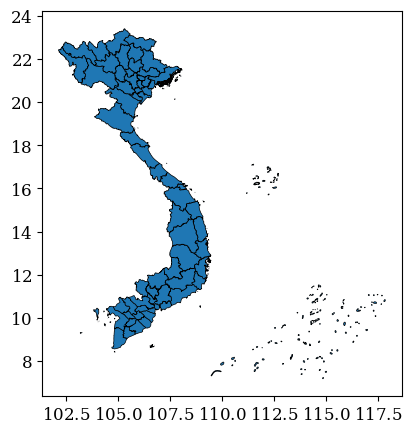

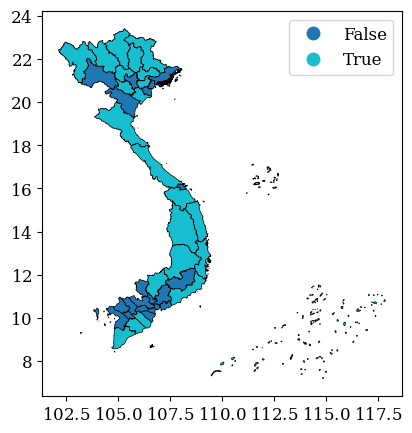

In [78]:
boundaries.plot(figsize=(5, 5), edgecolor='black', linewidth=0.5)
hybrid_gdf.plot(column='is_hybrid', legend=True, figsize=(5, 5), edgecolor='black',
        linewidth=0.5)

In [79]:
hybrid_gdf.to_file('./shapefiles/hybrid_shapefiles/vietnam_hybrid_boundaries.shp')

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_87974/1601179595.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hybrid_gdf.to_file('./shapefiles/hybrid_shapefiles/vietnam_hybrid_boundaries.shp')
/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field date create as date field, though DateTime requested.
  ogr_write(
/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field validOn create as date field, though DateTime requested.
  ogr_write(
/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'merged_provinces' to 'merged_pro'
  ogr_write(
/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'earliest_change_year' to 'earliest_c'
  o